In [2]:
library(tidyverse)
library(vroom)
library(scales)
library(viridis)

── Attaching core tidyverse packages ────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.3     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.4     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.0
✔ purrr     1.0.2     
── Conflicts ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors

Attaching package: ‘vroom’


The following objects are masked from ‘package:readr’:

    as.col_spec, col_character, col_date, col_datetime, col_double,
    col_factor, col_guess, col_integer, col_logical, col_number,
    col_skip, col_time, cols, cols_condense, cols_only, date_

In [3]:
files = Sys.glob("data/gwas/output_no_env/*.fixeff.txt")

In [4]:
dat = vroom(files,id="filename")

Rows: 9400 Columns: 5
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): method, term
dbl (2): estimate, se

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [5]:
dat = dat %>%
    extract(filename,into=c("split_time"),regex = "([0-9]+)_[0-9]+\\.fixeff\\.txt") %>%
    mutate(split_time = ifelse(split_time=="05","1e5",split_time)) %>%
    type_convert()


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  split_time = col_double(),
  method = col_character(),
  term = col_character()
)



`summarise()` has grouped output by 'split_time'. You can override using the `.groups` argument.
Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


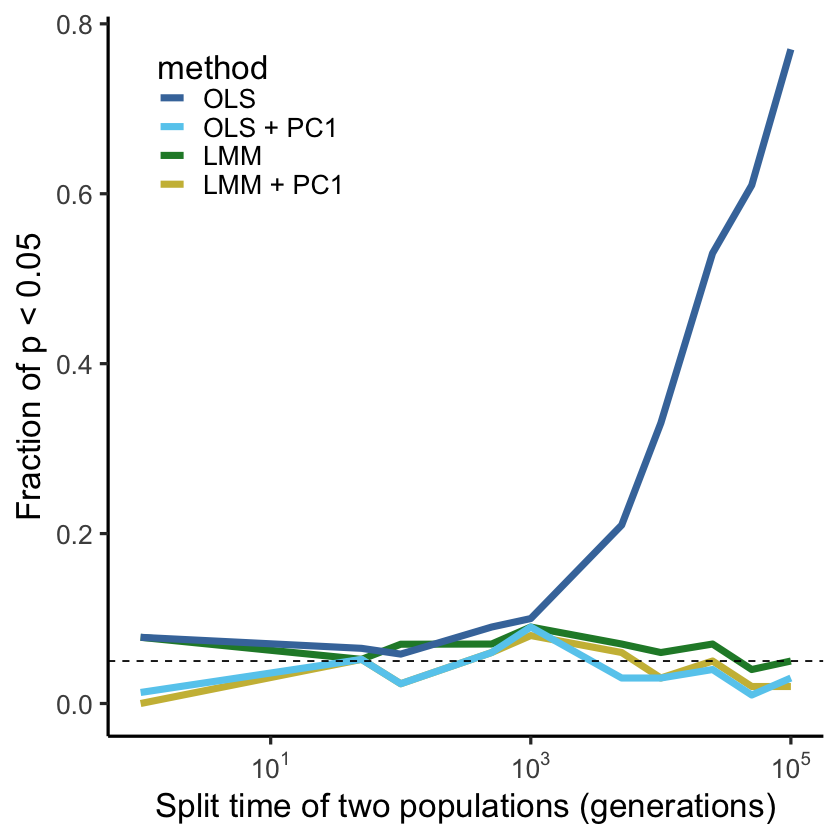

In [6]:
dat %>% mutate(p_value = 2*pnorm(abs(estimate),0,sd=se,lower.tail=FALSE)) %>%
    filter(term=="X") %>%
    group_by(split_time,method) %>%
    mutate(method = 
        case_when(
            method=="OLS" ~ "OLS",
            method=="OLS_PC" ~ "OLS + PC1",
            method=="GLS" ~ "LMM",
            method=="GLS_PC" ~ "LMM + PC1"
        )
    ) %>%
    summarise(FPR = mean(p_value<0.05,na.rm=TRUE)) %>% 
    ggplot(aes(split_time,FPR)) +
    geom_line(aes(color=method),size=2) +
    scale_x_log10(labels=label_log()) +
    geom_hline(yintercept=0.05,linetype=2) +
    theme_classic(base_size=20) +
    xlab("Split time of two populations (generations)") +
    ylab("Fraction of p < 0.05") + 
    theme(legend.position=c(.2,.85),legend.spacing.y = unit(1,"pt")) +
    scale_color_manual(values=c("#4477AA","#66CCEE","#228833","#CCBB44"),breaks = c("OLS","OLS + PC1", "LMM", "LMM + PC1"))

In [7]:
files_shift = Sys.glob("data/gwas/output_shift/*.fixeff.txt")

In [8]:
dat_shift = vroom(files_shift,id="filename")

Rows: 10000 Columns: 5
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (2): method, term
dbl (2): estimate, se

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [9]:
dat_shift = dat_shift %>%
    extract(filename,into=c("std"),regex = "([0-9]+\\.?[0-9]*)_[0-9]+\\.fixeff\\.txt") %>%
    type_convert() 


── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
cols(
  std = col_double(),
  method = col_character(),
  term = col_character()
)



`summarise()` has grouped output by 'std'. You can override using the `.groups` argument.


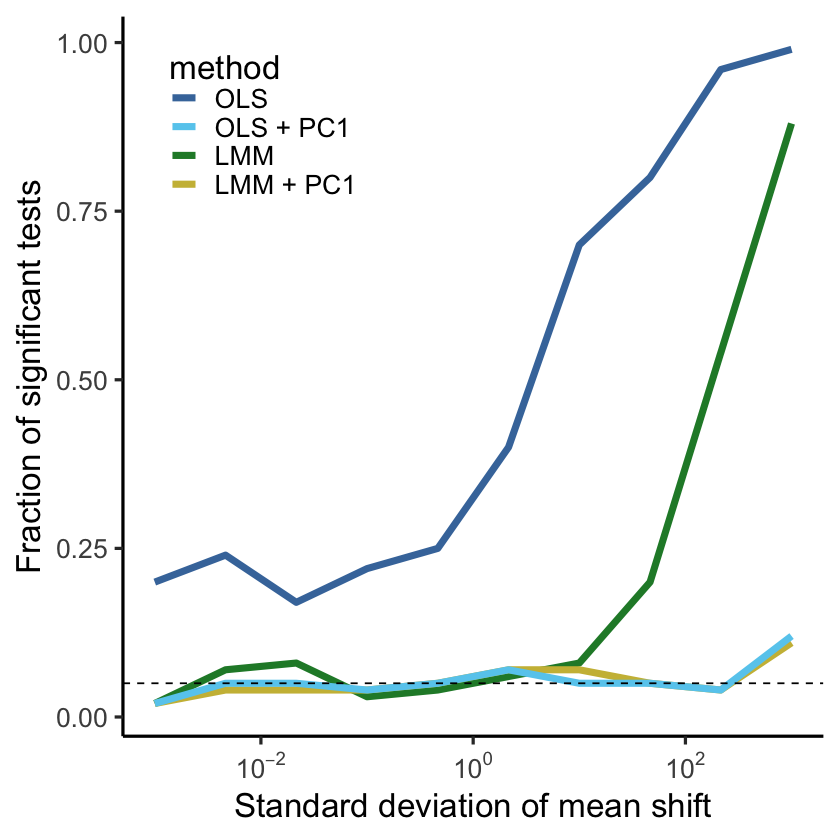

In [10]:
dat_shift %>% mutate(p_value = 2*pnorm(abs(estimate),0,sd=se,lower.tail=FALSE)) %>%
    filter(term=="X") %>% 
    group_by(std,method) %>%
    summarise(FPR = mean(p_value<0.05,na.rm=TRUE)) %>% 
    mutate(method = 
        case_when(
            method=="OLS" ~ "OLS",
            method=="OLS_PC" ~ "OLS + PC1",
            method=="GLS" ~ "LMM",
            method=="GLS_PC" ~ "LMM + PC1"
        )
    ) %>%
    ggplot(aes(std,FPR)) +
    geom_line(aes(color=method),size=2) +
    scale_x_log10(labels=label_log()) +
    geom_hline(yintercept=0.05,linetype=2) +
    theme_classic(base_size=20) +
    xlab("Standard deviation of mean shift") +
    ylab("Fraction of significant tests") +
    theme(legend.position=c(.2,.85),legend.spacing.y = unit(1,"pt")) +
    scale_color_manual(values=c("#4477AA","#66CCEE","#228833","#CCBB44"),breaks = c("OLS","OLS + PC1", "LMM", "LMM + PC1"))

In [11]:
files_big_tree = Sys.glob("data/gwas/output_20_tip/*.fixeff.txt")

In [12]:
dat_big_tree = vroom(files_big_tree)

Rows: 100266 Columns: 4
── Column specification ──────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Delimiter: "\t"
chr (1): method
dbl (3): estimate, se, PC

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


`summarise()` has grouped output by 'method'. You can override using the `.groups` argument.


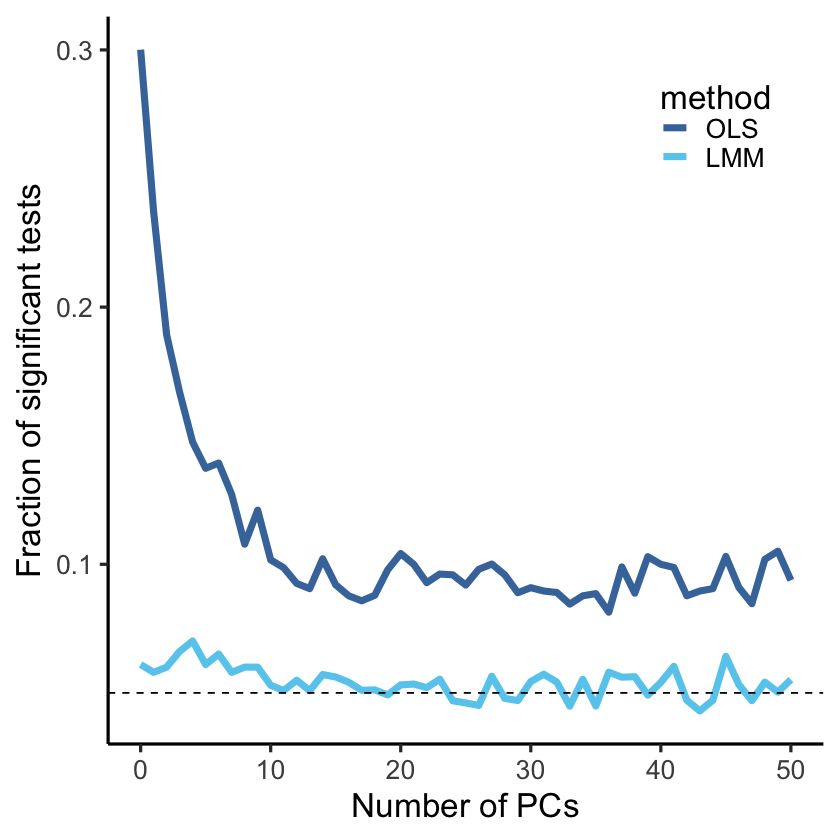

In [13]:
dat_big_tree %>% 
    mutate(p_value = 2*pnorm(abs(estimate),0,sd=se,lower.tail=FALSE)) %>%
    group_by(method,PC) %>%
    mutate(method=ifelse(method=="GLS","LMM",method)) %>% 
    summarise(FPR = mean(p_value<0.05,na.rm=TRUE)) %>%
    ggplot(aes(PC,FPR)) +
    geom_line(aes(color=method),size=2) +
    geom_hline(yintercept=0.05,lty=2) +
    xlab("Number of PCs") +
    ylab("Fraction of significant tests") +
    theme_classic(base_size=20) +
    theme(legend.position=c(.85,.85),legend.spacing.y = unit(1,"pt")) +
     scale_color_manual(values=c("#4477AA","#66CCEE","#228833","#CCBB44"),breaks = c("OLS","LMM"))